In [9]:
import pandas as pd
import numpy as np


def load_financial_data(start_date, end_date):
    df = pd.read_json("../data/example00593.json", orient='series')
    df = df.set_index('date')
    df = df.loc[start_date:end_date]
    return df

In [10]:
def create_classification_trading_condition(df):
    df['Open-Close'] = df.open - df.close
    df['High-Low'] = df.high - df.low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['close'].shift(-1) > df['close'], 1 , -1)
    return (df, X, Y)

In [14]:
def create_regression_trading_condition(df):
    df['Open-Close'] = df.open - df.close
    df['High-Low'] = df.high - df.low
    df['Target'] = df['close'].shift(-1) - df['close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

In [15]:
from sklearn.model_selection import train_test_split

def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

array([[<AxesSubplot:xlabel='Open-Close', ylabel='Open-Close'>,
        <AxesSubplot:xlabel='High-Low', ylabel='Open-Close'>,
        <AxesSubplot:xlabel='Target', ylabel='Open-Close'>],
       [<AxesSubplot:xlabel='Open-Close', ylabel='High-Low'>,
        <AxesSubplot:xlabel='High-Low', ylabel='High-Low'>,
        <AxesSubplot:xlabel='Target', ylabel='High-Low'>],
       [<AxesSubplot:xlabel='Open-Close', ylabel='Target'>,
        <AxesSubplot:xlabel='High-Low', ylabel='Target'>,
        <AxesSubplot:xlabel='Target', ylabel='Target'>]], dtype=object)

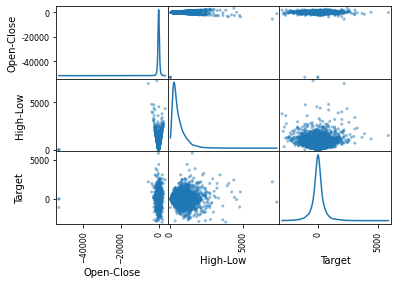

In [50]:
s_data = load_financial_data(start_date='2001-01-01', end_date='2023-03-15')
s_data, X, Y = create_regression_trading_condition(s_data)
pd.plotting.scatter_matrix(s_data[['Open-Close', 'High-Low', 'Target']], grid=True, diagonal='kde')

In [51]:
X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)

In [52]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)
print('Coefficients: \n', ols.coef_)

Coefficients: 
 [[0.00610312 0.03469313]]


In [53]:
from sklearn.metrics import mean_squared_error, r2_score

print("Mean squared error: %.2f"% mean_squared_error(Y_train, ols.predict(X_train)))

print("Variance score: %.2f"% r2_score(Y_train, ols.predict(X_train)))

print("Mean squared error: %.2f"% mean_squared_error(Y_test, ols.predict(X_test)))

print("Variance score: %.2f"% r2_score(Y_test, ols.predict(X_test)))

Mean squared error: 149673.97
Variance score: 0.00
Mean squared error: 915719.31
Variance score: 0.00


             open   high    low  close    volume  Open-Close  High-Low  \
date                                                                     
2001-01-02   3160   3380   3140   3350    789127        -190       240   
2001-01-03   3229   3420   3220   3370    757143        -141       200   
2001-01-04   3790   3870   3660   3780   2398248          10       210   
2001-01-05   3760   3920   3700   3900   1562744        -140       220   
2001-01-08   3820   3910   3780   3880    845911         -60       130   
...           ...    ...    ...    ...       ...         ...       ...   
2023-03-08  60100  60500  59900  60300  14161857        -200       600   
2023-03-09  60500  60800  59900  60100  14334499         400       900   
2023-03-10  59500  59700  59100  59500  11902471           0       600   
2023-03-13  59900  60200  59300  60000  12779724        -100       900   
2023-03-14  59400  59500  59000  59000  12147346         400       500   

            Target  predicted_signal 

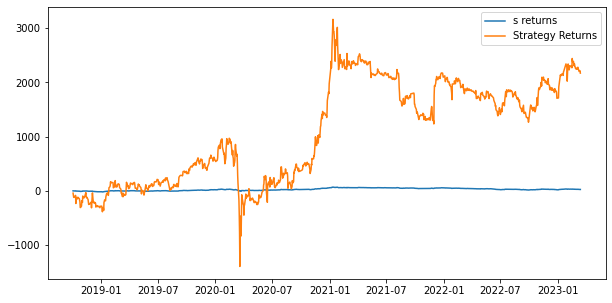

In [58]:
import matplotlib.pyplot as plt

s_data['predicted_signal'] = ols.predict(X)
s_data['s_returns'] = np.log(s_data['close'] / s_data['close'].shift(1))
print(s_data)

def calculate_return(df, split_value, symbol):
    cum_s_return = df[split_value:]['%s_returns' % symbol].cumsum() * 100
    df['strategy_return'] = df['%s_returns' % symbol] * df['predicted_signal'].shift(1)
    return cum_s_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['strategy_return'].cumsum() * 100
    return cum_strategy_return

cum_s_return = calculate_return(s_data, split_value=len(X_train), symbol='s')
cum_strategy_return = calculate_strategy_return(s_data, split_value=len(X_train), symbol='s')

def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()

plot_chart(cum_s_return, cum_strategy_return, symbol='s')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std 
    return sharpe.mean()

print(sharpe_ratio(cum_strategy_return, cum_s_return))

In [59]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)

print('Coefficients: \n', lasso.coef_)

Coefficients: 
 [0.00610308 0.03469203]


In [60]:
ridge = linear_model.Ridge(alpha=10000)
ridge.fit(X_train, Y_train)

print('Coefficients: \n', ridge.coef_)

Coefficients: 
 [[0.00610312 0.03469225]]


# KNN

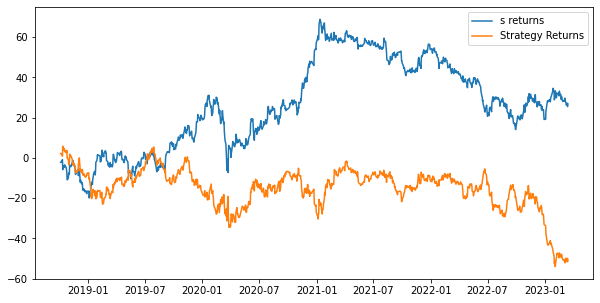

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


s_data = load_financial_data(start_date='2001-01-01', end_date='2023-03-15')
df, X, Y = create_classification_trading_condition(s_data)

X_train, X_test_, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

s_data['predicted_signal'] = knn.predict(X)

s_data['s_returns'] = np.log(s_data['close'] / s_data['close'].shift(1))

cum_s_return = calculate_return(s_data, split_value = len(X_train), symbol='s')
cum_strategy_return = calculate_strategy_return(s_data, split_value=len(X_train), symbol='s')

plot_chart(cum_s_return, cum_strategy_return, symbol='s')


# SVM

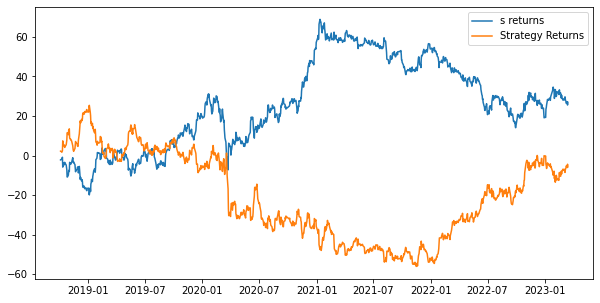

In [71]:
from sklearn.svm import SVC


svc = SVC()
svc.fit(X_train, Y_train)

s_data['predicted_signal'] = svc.predict(X)
s_data['s_returns'] = np.log(s_data['close'] / s_data['close'].shift(1))

cum_s_return = calculate_return(s_data, split_value = len(X_train), symbol='s')
cum_strategy_return = calculate_strategy_return(s_data, split_value = len(X_train), symbol='s')
plot_chart(cum_s_return, cum_strategy_return, symbol='s')

# Logistic Regression

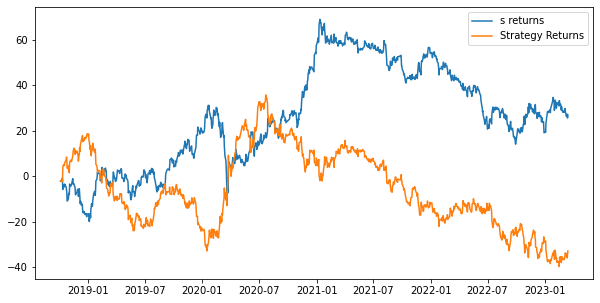

In [72]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train, Y_train)

s_data['predicted_signal'] = log.predict(X)

cum_s_return = calculate_return(s_data, split_value = len(X_train), symbol='s')
cum_strategy_return = calculate_strategy_return(s_data, split_value = len(X_train), symbol='s')
plot_chart(cum_s_return, cum_strategy_return, symbol='s')